## 0. Ambiente de trabalho e importação de bibliotecas

In [5]:
# Bibliotecas - API
import requests

# Bibliotecas - Gráficos
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# Bibliotecas - Dash
import dash
from dash import dcc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

C:\Users\ghumb\AppData\Local\Temp\ipykernel_21928\1954264805.py:18: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\ghumb\AppData\Local\Temp\ipykernel_21928\1954264805.py:19: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



## 1. ETL 
#### (extração de dados)


In [6]:

# define url incrementada para requisição de api (ate 1.000.000 registros)
url = "https://dadosabertos.aneel.gov.br/api/action/datastore_search?resource_id=b1bd71e7-d0ad-4214-9053-cbd58e9564a7&limit=1000000"

# tempo máximo de espera para a resposta da requisição
timeout_seconds = 100   

# Obter os dados da API
def get_data(url, timeout_seconds):
    try:
        # Requisição GET com o tempo limite definido
        response = requests.get(url, timeout=timeout_seconds)

        #  Verifica erros HTTP
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print("Erro ao obter os dados:", e)
        return None

    # Código de status da resposta HTTP=200, indicando que a requisição foi bem sucedida
    if response.status_code == 200:
        # Em caso de sucesso, obtenha os dados em formato JSON e imprima "Requisição bem sucedida"
        data = response.json()
        print("Requisição bem sucedida")

        # Verificar resposta da API
        if data["success"]:
            # Gera lista de registros e a lista de colunas
            records = data["result"]["records"]
            columns = data["result"]["fields"]

            # Adiciona as colunas "Bandeira" e "Nome_agente" na lista de colunas
            columns.append({"id": "Bandeira", "type": "text"})
            columns.append({"id": "Nome_agente", "type": "text"})

            # Cria o DataFrame
            df = pd.DataFrame.from_records(records, columns=[c["id"] for c in columns])

            # Retorne o DataFrame criado
            return df
        else:
            # Em caso de erro, imprir uma mensagem de aviso e retorne None
            print("A API não retornou dados.")
            return None
    else:
        # Se o código de status da resposta HTTP for diferente de 200, trate o erro de acordo com o código
        if response.status_code == 400:
            print("Requisição mal formada.")
        elif response.status_code == 401:
            print("Não autorizado.")
        elif response.status_code == 403:
            print("Acesso proibido.")
        elif response.status_code == 404:
            print("Recurso não encontrado.") 
        elif response.status_code == 500:
            print("Erro interno do servidor.")
        else:
            print("Erro desconhecido ao obter os dados.")

        return None

# Chame a função get_data para obter um DataFrame com os dados da API
df = get_data(url, timeout_seconds)

Requisição bem sucedida


## 2. EDA
#### (estudo dos dados)

### 2.1 - Tratamento de dados


 #### Análises realizadas : verificações obtidas
    - Formato de dados: inicialmente, algumas colunas do DataFrame possuíam valores do tipo 'object', que foram atualizados para as classes corretas (e.g. 'datetime', 'float', 'int').
    - Análise de valores vazios: não foi identificado um padrão de valores vazios no DataFrame, porém isso não deve ser um problema, uma vez que não pretendemos utilizá-los.
    - Análise de valores nulos: também não foi identificado um padrão de valores nulos no DataFrame, o que não deve ser um problema para nossas análises.
    - Análise de valores duplicados: felizmente, não encontramos valores duplicados no DataFrame, o que é sempre um bom sinal.

Colunas duplicadas:  []
Linhas duplicadas:  0
                             +       %
Nome_agente              32000  100.00
Bandeira                 32000  100.00
NumCoordNSub             31964   99.89
NumCoordESub             31964   99.89
NomSubEstacao            31964   99.89
NumCoordEEmpreendimento  27821   86.94
NumCoordNEmpreendimento  27821   86.94
codUFibge                   54    0.17
codRegiao                   54    0.17
CodEmpreendimento            3    0.01


c:\Users\ghumb\AppData\Local\Programs\Python\Python311\Lib\site-packages\missingno\missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



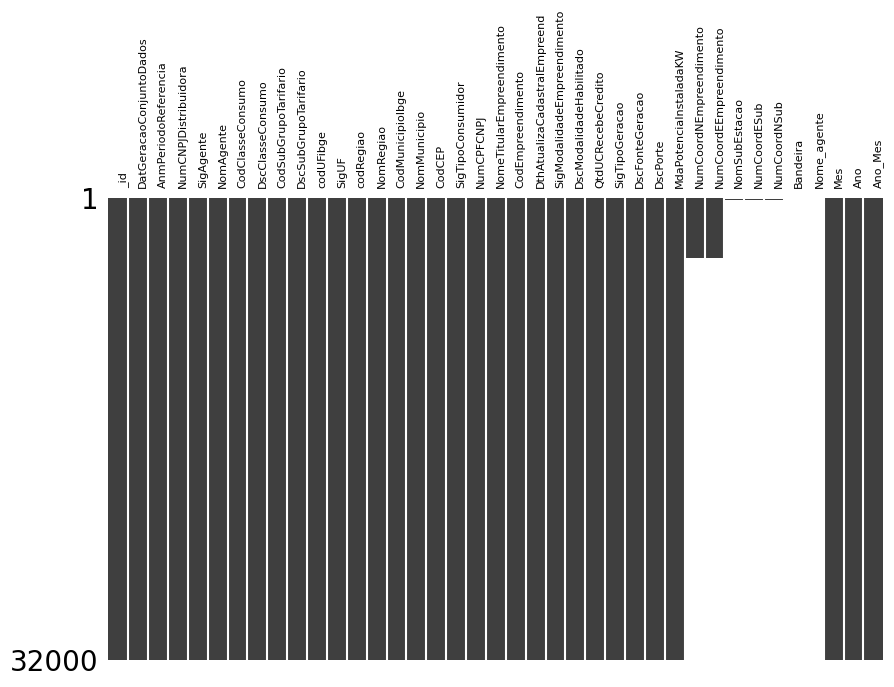

,_id,DatGeracaoConjuntoDados,AnmPeriodoReferencia,NumCNPJDistribuidora,SigAgente,NomAgente,CodClasseConsumo,DscClasseConsumo,CodSubGrupoTarifario,DscSubGrupoTarifario,...,NumCoordNEmpreendimento,NumCoordEEmpreendimento,NomSubEstacao,NumCoordESub,NumCoordNSub,Bandeira,Nome_agente,Mes,Ano,Ano_Mes
0,1,2023-03-29,03/2023,33050196000188,CPFL-PAULISTA,COMPANHIA PAULISTA DE FORÇA E LUZ,1,Residencial,9,B1,...,None,None,None,None,None,NaN,NaN,1,2023,2023-01
1,2,2023-03-29,03/2023,4895728000180,Equatorial PA,EQUATORIAL PARÁ DISTRIBUIDORA DE ENERGIA S.A.,1,Residencial,9,B1,...,None,None,None,None,None,NaN,NaN,2,2023,2023-02
2,3,2023-03-29,03/2023,4895728000180,Equatorial PA,EQUATORIAL PARÁ DISTRIBUIDORA DE ENERGIA S.A.,1,Residencial,9,B1,...,None,None,None,None,None,NaN,NaN,1,2023,2023-01
3,4,2023-03-29,03/2023,4065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,2,Comercial,11,B3,...,"-67,85","-9,96",None,None,None,NaN,NaN,7,2015,2015-07
4,5,2023-03-29,03/2023,4065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,1,Residencial,9,B1,...,"-70,78","-8,15",None,None,None,NaN,NaN,4,2015,2015-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,31996,2023-03-29,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,2,Comercial,11,B3,...,None,None,None,None,None,NaN,NaN,3,2018,2018-03
31996,31997,2023-03-29,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,2,Comercial,11,B3,...,None,None,None,None,None,NaN,NaN,3,2018,2018-03
31997,31998,2023-03-29,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,3,Rural,10,B2,...,None,None,None,None,None,NaN,NaN,3,2018,2018-03
31998,31999,2023-03-29,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,2,Comercial,11,B3,...,None,None,None,None,None,NaN,NaN,3,2018,2018-03


In [13]:

# Atualizando formato de colunas
def atualiza_formato_colunas(df):
    df = df.astype({
        "NumCNPJDistribuidora": np.int64,
        "CodClasseConsumo": np.int64,
        "CodSubGrupoTarifario": np.int64,
        "codUFibge": np.float64,
        "codRegiao": np.float64,
        "CodMunicipioIbge": np.float64,
        "QtdUCRecebeCredito": np.int64,
    })
    return df
df = atualiza_formato_colunas(df)

# análise de vazios
def analyze_dataframe(df):
    # Análise de colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    df_duplicated_col = df[duplicated_cols].sum()
    print('Colunas duplicadas: ', df_duplicated_col.tolist())

    # Análise de linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    df_duplicated_line = duplicated_rows.sum()
    print('Linhas duplicadas: ', df_duplicated_line.tolist())

    # Análise de valores nulos
    na_tot = df.isna().sum().sort_values(ascending=False)
    na_perc = (df.isna().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)
    na = pd.concat([na_tot, na_perc], axis=1, keys=['+', '%'])
    print(na.head(10))
analyze_dataframe(df)

def check_duplicates(df):
    # Verifica colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    num_duplicated_cols = len(duplicated_cols)
    
    # Verifica linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    num_duplicated_rows = duplicated_rows.sum()
    
    # Retorna o resultado
    return num_duplicated_cols, num_duplicated_rows



def visualizar_nulos(df):
    sorted_df = df.sort_values(by='NumCoordEEmpreendimento')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Cria a matriz de visualização de nulos com o eixo x em rotação vertical e tamanho de fonte menor
    matriz_nulos = msno.matrix(sorted_df, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
    plt.show()
visualizar_nulos(df)


# Adicionando as colunas Ano, Mes e Ano_Mes
def adiciona_colunas(df):
    df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
    df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
    df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')
    return df
adiciona_colunas(df)


### 2.2 - Estudando os dados - novos usuários

##### Objetivo principal: Estudar a serie temporal nos fatores
        - Conhecer os dados (tendências, sazonalidades, resíduos, autocorrelações, distribuição e outliers)
        - Definir os objetivos da previsão (interpretabilidade, simplicidade, escalabilidade, robustez)
        - Teste e validação

#### 2.2.1 - Organizando dfs p/ estudo (ts)

In [28]:
# Para não causar conflitos nos dados, criatemos df específicos para cada análise oriundos de simplificações de df

df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()
ts = df_clean.groupby(['DthAtualizaCadastralEmpreend', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
ts = ts.sort_values('DthAtualizaCadastralEmpreend')
ts = ts.set_index('DthAtualizaCadastralEmpreend')
ts_clean = ts.drop(['SigUF', 'SigTipoConsumidor','DscClasseConsumo'], axis=1)
ts_clean = ts_clean.groupby('DthAtualizaCadastralEmpreend').sum()

#### 2.2.2 Análises iniciais (Tendencia, estacionariedade, sazonalidade, residuo )

In [29]:
import statsmodels.api
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(ts_clean['NumCPFCNPJ'], period = 12)

tendencia = resultado.trend
sazonalidade = resultado.seasonal
residuo = resultado.resid

#### 2.2.3 Visualização gerao de novos usuários da rede por dia

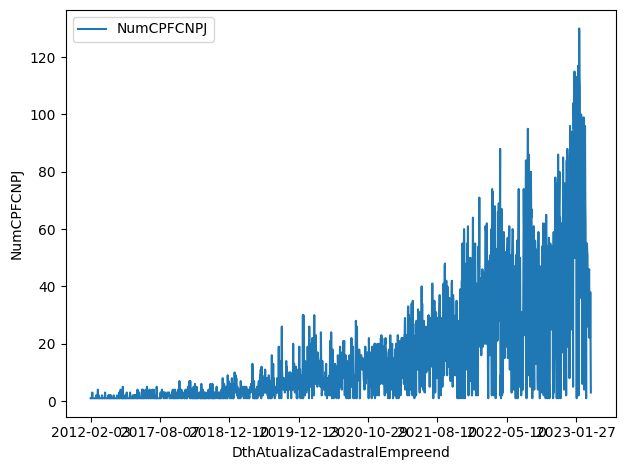

In [49]:
ts_clean.plot()
plt.xlabel('DthAtualizaCadastralEmpreend')
plt.ylabel('NumCPFCNPJ')
plt.tight_layout()

#### 2.2.4 - tendencia

Text(0.5, 1.0, 'Tendência')

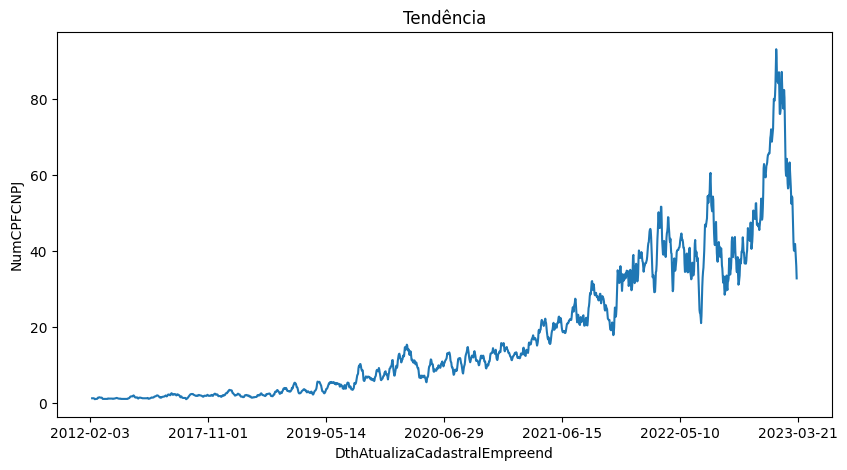

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tendencia)
ax.set_xlabel('DthAtualizaCadastralEmpreend')
ax.set_xticks(range(0, len(ts_clean), 300))
ax.set_ylabel('NumCPFCNPJ')
ax.set_title('Tendência')

# A tendencia de novos usuários por dia apresenta uma crescente até o fim de 2022

#### 2.2.5 - sazonalidade

Text(0.5, 1.0, 'sazonalidade')

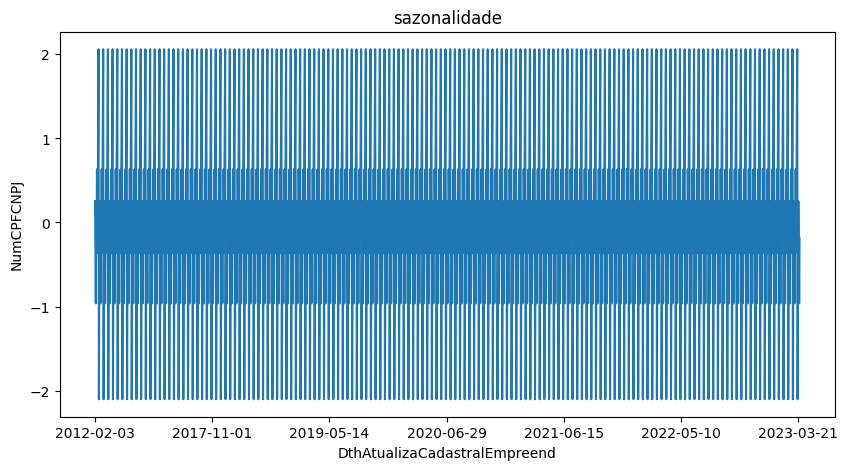

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sazonalidade)
ax.set_xlabel('DthAtualizaCadastralEmpreend')
ax.set_xticks(range(0, len(ts_clean), 300))
ax.set_ylabel('NumCPFCNPJ')
ax.set_title('sazonalidade')


#### 2.2.6 - resíduo

Text(0.5, 1.0, 'residuo')

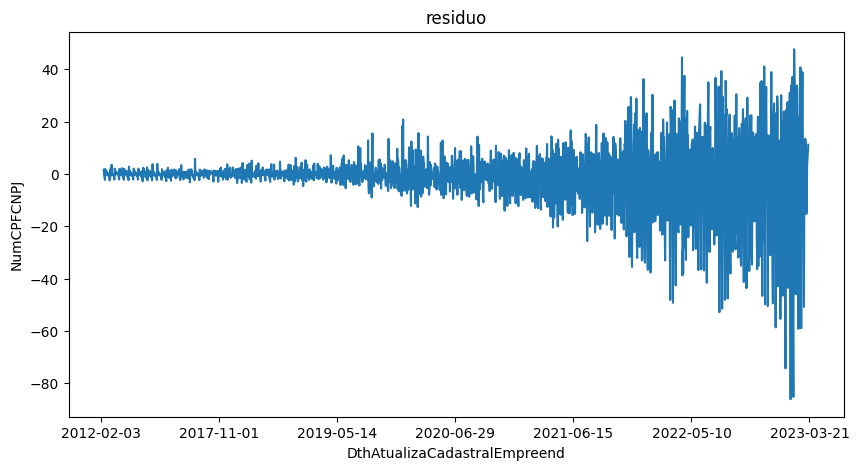

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(residuo)
ax.set_xlabel('DthAtualizaCadastralEmpreend')
ax.set_xticks(range(0, len(ts_clean), 300))
ax.set_ylabel('NumCPFCNPJ')
ax.set_title('residuo')

# O resíduo é a componente aleatória da série que não pode ser explicada pela tendência ou pela sazonalidade. O resíduo representa o erro do modelo e deve ser aleatório e não mostrar nenhum padrão discernível.
# O crescimento do resíduo pode indicar que o modelo não está capturando toda a variação nos dados ou que há algum padrão nos dados que o modelo não está conseguindo capturar1.

#### 2.2.7 - Estacionariedade

Uma série temporal é estacionária se a média e a variância da série não mudam ao longo do tempo. 

A estacionariedade é importante porque muitos modelos de séries temporais assumem que a série é estacionária ou que pode ser transformada em uma série estacionária.

##### 2.2.7.1 - ADF

In [63]:
from statsmodels.tsa.stattools import adfuller

resultado_ts = adfuller(ts_clean, autolag='AIC')
print('Estatística ADF: {:0.2f}'.format(resultado_ts[0]))
print('Número de atrasos: {}'.format(resultado_ts[2]))

# p<5% é um padrão estacionário, crescente controlado
print('Valor p: {:0.3f}'.format(resultado_ts[1]))
for key, value in resultado_ts[4].items():
    print('Valores críticos:')
    print("{}, {:0.2f}".format(key,value))


# ADF = -1.58 é um valor negativo, mas não muito negativo. Isso indica que a série é um pouco fria (um pouco estacionária), mas não o suficiente para rejeitar a hipótese nula de que a série tem uma raiz unitária (não é estacionária).

# P = 0.495 significa que há uma probabilidade de 49,5% de obter um valor da estatística ADF igual ou mais extremo do que o observado, assumindo que a hipótese nula é verdadeira. Isso é um valor p alto, o que sugere que não há evidência suficiente para rejeitar a hipótese nula de que a série tem uma raiz unitária (não é estacionária).

Estatística ADF: -1.58
Número de atrasos: 24
Valor p: 0.495
Valores críticos:
1%, -3.43
Valores críticos:
5%, -2.86
Valores críticos:
10%, -2.57


##### 2.2.7.2 - KPSS

KPSS = 5.67  é um valor muito alto, que indica que a série é muito não-estacionária - 
https://en.wikipedia.org/wiki/KPSS_test

O valor p de 0.01 significa que há uma probabilidade de 1% de obter um valor da estatística KPSS igual ou mais extremo do que o observado

In [64]:

from statsmodels.tsa.stattools import adfuller

resultado_ts = adfuller(ts_clean, autolag='AIC')
print('Estatística ADF: {:0.2f}'.format(resultado_ts[0]))
print('Número de atrasos: {}'.format(resultado_ts[2]))

# p<5% é um padrão estacionário, crescente controlado
print('Valor p: {:0.3f}'.format(resultado_ts[1]))
for key, value in resultado_ts[4].items():
    print('Valores críticos:')
    print("{}, {:0.2f}".format(key,value))


# KPSS é 5.67. Isso é um valor muito alto, que indica que a série é muito não-estacionária. - https://en.wikipedia.org/wiki/KPSS_test
# O valor p de 0.01 significa que há uma probabilidade de 1% de obter um valor da estatística KPSS igual ou mais extremo do que o observado

Estatística ADF: -1.58
Número de atrasos: 24
Valor p: 0.495
Valores críticos:
1%, -3.43
Valores críticos:
5%, -2.86
Valores críticos:
10%, -2.57


#### 2.2.8 - ACF (autocorrelação)

Mede a relação entre os valores da série e os seus valores anteriores em diferentes defasagens. 

Um ACF com um decaimento rápido sugere que há pouca ou nenhuma correlação entre as observações defasadas da série temporal.

    - Autocorrenação de pearson
        - acf > 0 = correlação positiva
        - acf < 0 = correlação negativa
        - acf = 0 = nenhuma correlação



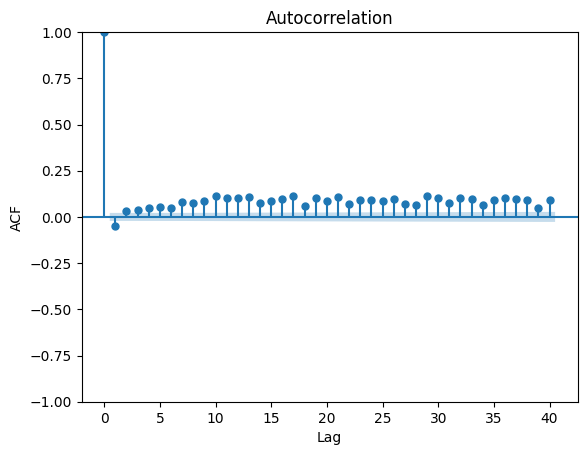

In [65]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts['NumCPFCNPJ'], lags=40)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

# Se uma autocorrelação está fora do intervalo "mancha azul", significa que ela é significativamente diferente de zero e indica algum padrão na série.
# A autocorrelação no lag 1 é positiva e está fora do intervalo de confiança, o que significa que há uma relação significativa entre o valor atual da série e o valor anterior. Isso pode indicar que a série tem algum componente autoregressivo (AR), ou seja, que depende dos seus próprios valores passados.
# As autocorrelações nos demais lags são próximas de zero e estão dentro do intervalo de confiança, o que significa que não há relações significativas entre o valor atual da série e os valores mais distantes no tempo. Isso pode indicar que a série não tem nenhum componente de média móvel (MA), ou seja, que não depende dos erros passados.

#### 2.2.9 - PACF (autocorrelação parcial)

A autocorrelação parcial é útil para identificar os termos autoregressivos (AR) em um modelo ARIMA. Se a autocorrelação parcial é significativa em um determinado lag, isso significa que há uma relação direta entre a observação atual e a observação nesse lag. O número de lags significativos indica a ordem do termo AR.

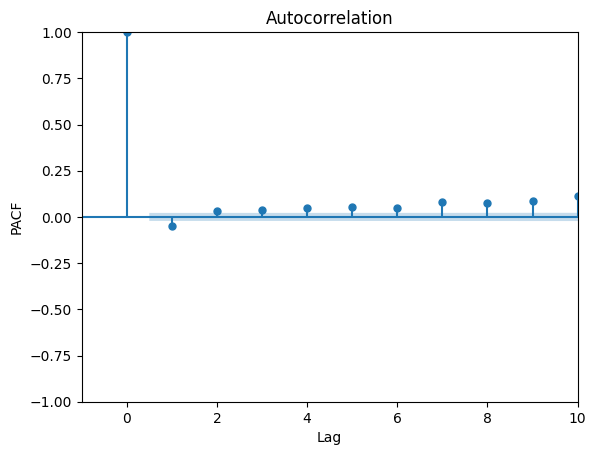

In [72]:
plot_acf(ts['NumCPFCNPJ'], lags=10, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.xlim([-1, 10])
plt.show()

# lag 0 é igual a 1, o que é esperado, pois significa que a série está correlacionada consigo mesma.

### 2.3 - Análises de interesse:


##### Análises da potencia instalada por tempo, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - 

##### Análises o agente instalada por grupo tarifario, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - 


##### Colunas adequadas para utilização: 

        - SigUF - nome do estado do empreendimento
        - NomMunicipio - nome do município do empreendimento

        - SigTipoConsumidor (PF ou PJ)
        - DthAtualizaCadastralEmpreend

        - DscClasseConsumo - descrição da classe de consumo do empreendimento
        - CodSubGrupoTarifario - código do subgrupo tarifário do empreendimento

        - DscFonteGeracao - descrição da fonte de geração do empreendimento

        - NomAgente - nome do agente 
        - DscPorte - descrição do porte do agente
        - MdaPotenciaInstaladaKW - potência instalada do agente em kW

##### Evoluções do número de usuários por tempo, segmentado por: 

        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - DscClasseConsumo (resid/comercial/industrial) e SigUF(uf)


In [74]:

# agrupa os dados
counts = df_clean.groupby(['Ano', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
# ERRADO - tx_anual_tipo = counts.groupby(['NumCPFCNPJ', 'SigTipoConsumidor'])['Ano'].apply(lambda x: x.pct_change().mean())
# ERRADO - tx_anual_classe = counts.groupby(['NumCPFCNPJ', 'DscClasseConsumo'])['Ano'].apply(lambda x: x.pct_change().mean())


# seria bom adicionar uma linha com a taxa de crescimento anual por Tipo de Consumidor
def grafico_novos_usuarios_tipo(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_tipo = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='SigTipoConsumidor')
    fig_novos_tipo.update_layout(
        width=1200,
        height=600,
        xaxis_title='Ano',
        xaxis_title_font_size=16,
        yaxis_title='Novos usuários',
        yaxis_title_font_size=16,
        title='Novos usuários por tipo de consumo',
        title_font_size=20,
        title_x=.5
    )
    fig_novos_tipo.show()
grafico_novos_usuarios_tipo(counts)
#grafico_novos_usuarios_tipo(counts)


# Tornar a o eixo y variável pelo max de cada UF
def grafico_novos_usuarios_tipo_UF(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_tipo_uf = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='SigTipoConsumidor',barmode="group", facet_row="SigUF")
    fig_novos_tipo_uf.update_layout(
        width=800,
        height=600,
        title={
        'text': "Novos usuários",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )

    fig_novos_tipo_uf.show()
grafico_novos_usuarios_tipo_UF(counts)


In [7]:
def grafico_novos_usuarios_classe(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_classe = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='DscClasseConsumo')
    fig_novos_classe.update_layout(
        width=1200,
        height=600,
        xaxis_title='Ano',
        xaxis_title_font_size=16,
        yaxis_title='Novos usuários',
        yaxis_title_font_size=16,
        title='Novos usuários por tipo de consumo',
        title_font_size=20,
        title_x=.5
    )
    fig_novos_classe.show()
grafico_novos_usuarios_classe(counts)


def grafico_novos_usuarios_classe_UF(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_classe_uf = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='DscClasseConsumo',barmode="group", facet_row="SigUF")
    fig_novos_classe_uf.update_layout(
        width=800,
        height=600,
        title={
        'text': "Novos usuários",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )
    fig_novos_classe_uf.show()
grafico_novos_usuarios_classe_UF(counts)


In [ ]:










## tentativa de incrementar o gráfico com a taxa de crescimento anual

counts2 = pd.DataFrame(df_clean.groupby(['Ano', 'SigUF','SigTipoConsumidor'])['NumCPFCNPJ'].nunique()).reset_index()
counts2['TaxaCrescimento'] = counts.groupby(['SigTipoConsumidor', 'Ano'])['NumCPFCNPJ'].pct_change() * 100
counts2['TaxaCrescimento'] = counts['TaxaCrescimento'].replace([np.inf, -np.inf], np.nan)

counts2













##### #_____________________GRÁFICOS DO app.py, MUITO CUIDADO!____________________#

In [ ]:
# O gráfico 1 mostra a evolução temporal do Total Mensal de Empreendimentos por Estado e por Classe de Consumo;

    # OBS1: estados com menos de 10 empreendimentos foram excluídos do gráfico;
    # OBS2: os dados de 2023 representam um corte até hoje


# agrupa os dados
counts = df_clean.groupby(['Ano_Mes', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()

# Cria uma lista com as opções de SigUF para dropdown
sigufs = df_clean['SigUF'].unique()

# cria o gráfico de áreas empilhadas

fig_3 = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color="DscClasseConsumo", title="Novos usuários da rede distribuida")

# estilo do grafico
fig_3.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano_Mes',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='NumCPFCNPJ',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)


fig_3.update_yaxes(range=[0, 6000])

In [76]:
#___________________________________________________Gráfico 2__________________________________________________#

df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')

# cria uma cópia do DataFrame sem valores nulos de NumCPFCNPJ
df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()

# filtra apenas as SigUFs desejadas
df_clean = df_clean[df_clean['SigUF'].isin(['BA', 'AL', 'AC', 'AM', 'AP'])]

# agrupa os dados por ano, mês, SigUF e DscClasseConsumo
counts = df_clean.groupby(['Ano_Mes', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()

# Cria uma lista com as opções de SigUF
sigufs = df_clean['SigUF'].unique()

# cria o gráfico de áreas empilhadas animado

fig_3 = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color="DscClasseConsumo", title="Novos usuários da Energia distribuida")

fig_3.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano_Mes',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='NumCPFCNPJ',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)

# Define a faixa de valores do eixo y de acordo com os dados do gráfico
fig_3.update_yaxes(range=[0, 7000])

In [77]:

##___________MATRIZES_____________##

df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()
matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')

matriz['Total'] = matriz.sum(axis=1)
matriz = matriz.fillna(0)

matriz_tx = matriz.iloc[:, :-1].pct_change(axis=1) * 100
matriz_tx= matriz.applymap(lambda x: '{:.0f}%'.format(x) if not np.isinf(x) else '∞')

matriz



Ano,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total
SigUF,,,,,,,,,,,,,
AC,0.0,0.0,0.0,3.0,1.0,16.0,31.0,132.0,504.0,1409.0,1797.0,375.0,4268.0
AL,0.0,0.0,0.0,4.0,14.0,46.0,173.0,617.0,1612.0,3496.0,8152.0,3086.0,17200.0
AM,0.0,0.0,0.0,2.0,5.0,20.0,81.0,428.0,880.0,1582.0,2855.0,863.0,6716.0
AP,0.0,0.0,0.0,0.0,0.0,2.0,36.0,108.0,145.0,477.0,908.0,606.0,2282.0
BA,1.0,1.0,15.0,35.0,106.0,266.0,90.0,4.0,1.0,3.0,3.0,1.0,526.0


In [78]:

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()
matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')

matriz['Total'] = matriz.sum(axis=1)
matriz = matriz.fillna(0)

matriz_tx = matriz.iloc[:, :-1].pct_change(axis=1) * 100
matriz_tx= matriz.applymap(lambda x: '{:.0f}%'.format(x) if not np.isinf(x) else '∞')


counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()
matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')

matriz.loc['BR'] = matriz.sum()


matriz = matriz.fillna(0)

z_text = matriz.round(2).values.tolist()

fig = ff.create_annotated_heatmap(z=matriz.values,
                                  x=list(matriz.columns),
                                  y=list(matriz.index),
                                  annotation_text=z_text,
                                  font_colors=['gray', 'white'],
                                  colorscale='YlGnBu')

fig.update_layout(yaxis={'type': 'category'})


fig.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='SigUF',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)

fig.show()

In [80]:


df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()

matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')
matriz = matriz.fillna(0)
matriz.loc['BR'] = matriz.sum()

matriz_tx = matriz.pct_change(axis=1) * 100
matriz_tx = matriz_tx.applymap(lambda x: '{:.0f}%'.format(x) if not np.isnan(x) and x != 0 else ' ')
matriz_tx['med'] = ""
matriz_tx['Total'] = ""
matriz_tx['2023'] = ""





import plotly.graph_objs as go
import plotly.figure_factory as ff
import numpy as np

# Criando uma lista de strings com valores da matriz e matriz_tx
text = [[f"{matriz.iloc[i,j]:}<br>{matriz_tx.iloc[i,j]}" for j in range(len(matriz.columns))] for i in range(len(matriz.index))]
# Criação do heatmap principal
fig_2 = ff.create_annotated_heatmap(z=matriz.values,
                                  x=list(matriz.columns),
                                  y=list(matriz.index),
                                  annotation_text=text,
                                  font_colors=['gray', 'white'],
                                  colorscale='YlGnBu')
# Configurações de layout
fig_2.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='SigUF',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)    

fig_2.show()



In [81]:
###_________PROPHET__________##


import pandas as pd
import plotly.express as px
from fbprophet import Prophet

# Manipulações para Gráfico - evolução temporal da Potência Instalada Total (KW) por Estado;
df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

# Agrupar dados por mês, ano e estado e somar as potências instaladas
counts = df.groupby(['SigUF', 'Ano', 'Mes']).agg({'MdaPotenciaInstaladaKW': 'sum'}).reset_index()

# Renomear as colunas para ds e y, que são as convenções do Prophet
counts = counts.rename(columns={'Ano': 'ds', 'MdaPotenciaInstaladaKW': 'y'})

# Filtrar apenas os dados do estado desejado para fazer a previsão
state_counts = counts[counts['SigUF'] == 'UF']

# Ajustar um modelo com a biblioteca Prophet
m = Prophet()
m.fit(state_counts)

# Fazer a previsão para o período desejado (2023)
future = m.make_future_dataframe(periods=12*10, freq='M')  # 10 anos de previsão
forecast = m.predict(future)

# Criar gráfico com os dados históricos e a previsão
fig = px.line(forecast, x='ds', y='yhat', title='Previsão de Potência Instalada em UF')
fig.add_scatter(x=state_counts['ds'], y=state_counts['y'], name='Histórico', mode='markers')
fig.show()

ModuleNotFoundError: No module named 'fbprophet'

## EDA previsões